In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [15]:
path = '../input/'
comp = 'germeval2018/'
TRAIN_DATA_FILE=f'{path}{comp}germeval2018.training.txt'
TEST_DATA_FILE=f'{path}{comp}germeval2018.test.txt'
EMBEDDING_FILE=f'{path}embed_tweets_de_200M_200D/embedding_file'


In [16]:
#same seed to make classifier output reproducible
from numpy.random import seed
seed = 1
np.random.seed(seed)

In [17]:
embed_size = 200 # how big is each word vector
max_features = 15909 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

# Preprocessing

In [18]:
import re
import re
import sys


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URLTOK ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USRTOK', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', 'rt', tweet)
    words = tweet.split()

    for word in words:
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

Read in our data 

In [19]:
train = pd.read_csv(TRAIN_DATA_FILE, sep="\t", header=None)
#switch columns
train = train[[1,0]]
train.columns = ['sentiment', 'tweet_text']
train.applymap(lambda x: x.strip() if type(x) is str else x)
train['tweet_text'] = train['tweet_text'].apply(lambda x: preprocess_tweet(x))

mapping = {'OTHER': 0, 'OFFENSE': 1}
train = train.replace({'sentiment': mapping})
train['sentiment'] = train['sentiment'].astype(np.float32)

list_sentences_train = train.tweet_text
y_train = train['sentiment'].values



In [20]:
list_sentences_train[4672]

'USRTOK USRTOK jetzt bekommt merkel noch grüne untergangs-beschleuniger dabei!'

In [21]:
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
#switch column
test.columns = ['tweet_text']
test.applymap(lambda x: x.strip() if type(x) is str else x)
test['tweet_text'] = test['tweet_text'].apply(lambda x: preprocess_tweet(x))


#mapping = {'OTHER': 0, 'OFFENSE': 1}
#test = test.replace({'sentiment': mapping})
#test['sentiment'] = test['sentiment'].astype(np.float32)

list_sentences_test = test.tweet_text
#y_test = test.sentiment.values

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [22]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [23]:
X_t

array([[    0,     0,     0, ...,  2173,    62,  5990],
       [    0,     0,     0, ...,  5991,  1318,    18],
       [    0,     0,     0, ...,   163,  3737,  3738],
       ...,
       [    0,     0,     0, ...,   912,    38,   354],
       [    0,     0,     0, ...,     3, 15905,  1860],
       [    0,     0,     0, ...,  1417,    15, 15908]], dtype=int32)

Read the spinningbytes word vectors (space delimited strings) into a dictionary from word->vector.

In [24]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [25]:
values = embeddings_index.values()
for val in values:
    if len(val) != 200:
        print(len(val))

1


In [26]:
keys = list(embeddings_index.values())
keys.pop(0)
keys

[array([ 0.117924, -0.168538,  0.094732, -0.105124,  0.220136, -0.073818,
        -0.08892 ,  0.015829,  0.036287,  0.244584, -0.03181 ,  0.030488,
        -0.071545, -0.293321, -0.266399,  0.012286, -0.029214, -0.099929,
        -0.037632,  0.103478, -0.165855, -0.012233,  0.369934, -0.298706,
         0.102586,  0.130064,  0.297194,  0.041375, -0.117876, -0.021119,
        -0.010795,  0.229406, -0.184331,  0.06865 ,  0.002124, -0.117511,
         0.063039, -0.161647, -0.09431 , -0.069767, -0.176231, -0.098392,
        -0.3097  , -0.051246, -0.164406,  0.022235, -0.128269,  0.162794,
        -0.052192,  0.069443,  0.000775,  0.0094  ,  0.116911,  0.029682,
         0.134798, -0.186067, -0.081906, -0.040179, -0.097448, -0.054188,
         0.103623, -0.025233,  0.063151, -0.087836, -0.055747,  0.086032,
         0.132904, -0.157655, -0.089823, -0.098509,  0.094796, -0.015094,
         0.058892, -0.025936,  0.132185, -0.046392,  0.132517, -0.144694,
         0.205565,  0.116568,  0.05264

In [29]:
all_embs = np.stack(keys)
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.00042068152, 0.24969141)

Use these vectors to create our embedding matrix, with random initialization for words that aren't in the word embeddings. We'll use the same mean and stdev of embeddings the tweet embeddings have when generating the random init.

In [30]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [31]:
embedding_matrix.shape

(15909, 200)

In [32]:
embedding_matrix[1000]

array([ 5.41119985e-02,  1.96115002e-01, -1.42131999e-01,  2.70080008e-02,
        7.60390013e-02, -1.41380001e-02, -1.11661002e-01,  2.05010008e-02,
       -2.84375012e-01,  1.35187000e-01, -1.72693998e-01,  8.67289975e-02,
        1.39009999e-02, -3.25170994e-01,  6.67719990e-02, -5.20679988e-02,
       -3.81270014e-02, -2.16638997e-01,  5.86399995e-03,  3.60794991e-01,
       -8.77979994e-02, -1.85095996e-01,  2.07589995e-02,  1.25900004e-03,
       -1.22977003e-01,  2.16022000e-01,  2.42465004e-01,  1.73329994e-01,
       -2.11730003e-02, -1.95577994e-01, -1.56466007e-01, -2.30275005e-01,
       -2.05902994e-01, -1.62375003e-01,  1.26438007e-01, -2.16057003e-01,
        2.69098997e-01,  9.29099973e-03,  1.08966999e-01, -7.91999977e-03,
       -2.48077005e-01,  1.10716000e-01, -1.51537001e-01, -6.63190037e-02,
       -4.50860001e-02,  1.17261998e-01, -3.51494998e-01,  1.29637003e-01,
       -7.38999981e-04, -3.95597011e-01,  5.18166006e-01, -1.30132005e-01,
        4.66998011e-01, -

One-hot encoding of tweet labels

In [33]:
y_train_one_hot = np.zeros((X_t.shape[0], 2))
y_train_one_hot[np.arange(X_t.shape[0]),y_train.astype(np.int32)] = 1

Simple bidirectional LSTM and some dropout (to prevent overfitting)

In [84]:
from keras.layers import *
from keras.models import Model
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_t, y_train):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x) # changed to GRU (from LSTM)
    #x = Conv1D(64, kernel_size = 5, activation='relu')(x)
    x = GlobalMaxPool1D()(x) 
    #avg_pool = GlobalAveragePooling1D()(x)
    #max_pool = GlobalMaxPooling1D()(x)
    #x = concatenate([avg_pool, max_pool])
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x) # increased dropout because of overfitting (0.5 with 3 epochs seems good)
    x = Dense(2, activation="softmax")(x) 
    
    model = Model(inputs=inp, outputs=x)
    
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    rmsprop = optimizers.Adam(lr=0.001)
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy']) #changed optimizer from 'adam' to custom adam
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

    model.fit(X_t[train], y_train_one_hot[train], batch_size=32, epochs=10, validation_split=0.1, shuffle=True, callbacks=[reduce_lr,early_stopping]);

    scores = model.evaluate(X_t[test], y_train_one_hot[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 4056 samples, validate on 451 samples
Epoch 1/10
4056/4056 [==============================] - 40s 10ms/step - loss: 0.6452 - acc: 0.6568 - val_loss: 0.6164 - val_acc: 0.6541
Epoch 2/10
4056/4056 [==============================] - 20s 5ms/step - loss: 0.6148 - acc: 0.6674 - val_loss: 0.5491 - val_acc: 0.7517
Epoch 3/10
4056/4056 [==============================] - 20s 5ms/step - loss: 0.5012 - acc: 0.7547 - val_loss: 0.4906 - val_acc: 0.7783
Epoch 4/10
4056/4056 [==============================] - 20s 5ms/step - loss: 0.3420 - acc: 0.8508 - val_loss: 0.4560 - val_acc: 0.7960
Epoch 5/10
4056/4056 [==============================] - 20s 5ms/step - loss: 0.2119 - acc: 0.9186 - val_loss: 0.5500 - val_acc: 0.7827
Epoch 6/10
4056/4056 [==============================] - 20s 5ms/step - loss: 0.1346 - acc: 0.9512 - val_loss: 0.6366 - val_acc: 0.7783
acc: 76.49%
Train on 4057 samples, validate on 451 samples
Epoch 1/10
4057/4057 [==============================] - 41s 10ms/step - loss: 0.645

# Serialize Model to JSON

In [2]:
from keras.models import model_from_json
# serialize model to JSON
#model_json = model.to_json()
#with open("LSTM_model.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("LSTM_model.h5")
#print("Saved model to disk")

Using TensorFlow backend.


In [37]:
from keras.models import model_from_json

# load json and create model
json_file = open('LSTM_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("LSTM_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Loaded model from disk


# Get predictions on the test set

In [38]:
preds = model.predict(X_te, batch_size=32, verbose=1) 
print(preds[1,0])

3398/3398 [==============================] - 4s 1ms/step
0.21771085


In [39]:
pred_pos = preds.argmax(-1)
pred_pos = pred_pos.astype(float)
#print('Accuracy: ' + str(np.mean(pred_pos == y_test))) 

In [40]:
#from sklearn.metrics import confusion_matrix, classification_report
#print(classification_report(y_test, pred_pos))

## Predict probabilities

In [43]:
# create a submission
submission = pd.DataFrame(columns=['tweet_text', 'probabilities_neutral', 'probabilities_toxic'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['probabilities_neutral'] = preds[:,0] 
submission['probabilities_toxic'] = preds[:,1]
# dummy value
submission.to_csv(f"{path}{comp}LSTM_probabilities.txt", sep="\t", index=False, header=False)

## Create submission file

In [44]:
# create a submission
submission = pd.DataFrame(columns=['tweet_text', 'binary', 'multiclass'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['binary'] = pred_pos 
mapping = {0 :'OTHER', 1: 'OFFENSE'}
submission = submission.replace({'binary': mapping})
# dummy value
submission['multiclass'] = 'OTHER'
submission.to_csv(f"{path}{comp}LSTM_submit.txt", sep="\t", index=False, header=False)

# Receiver Operating Characteristcs

In [105]:
y_test_one_hot = np.zeros((X_te.shape[0], 2))
y_test_one_hot[np.arange(X_te.shape[0]),y_test.astype(np.int32)] = 1
pred_pos_one_hot = np.zeros((X_te.shape[0], 2))
pred_pos_one_hot[np.arange(X_te.shape[0]),pred_pos.astype(np.int32)] = 1

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

In [107]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, preds[:,i])

    roc_auc[i] = auc(fpr[i], tpr[i])


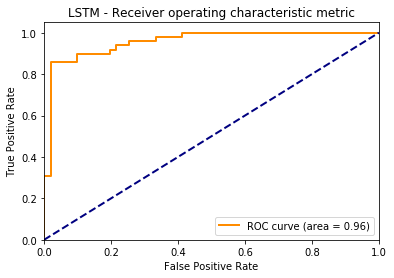

In [108]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM - Receiver operating characteristic metric')
plt.legend(loc="lower right")
plt.show()

In [109]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_pos)

array([[50,  1],
       [ 9, 40]])